# Data Exploration (Part VIIII - Lat Long Visualization By Category)
## Review
This is a direct continuation of last post, so I won't review too much. Last time, we mapped NYPD complaint / offense density geographically using datashader. We explored the ideas of color gradients, color gradient floors, histogram equalization, and looking at top x% of densities.

Here, we will look at categorical mapping, which allows us to view the density _**by data category**_.

### Load Data

In [1]:
import os
os.system("sudo pip install fastparquet s3fs python-snappy")

0

In [1]:
import s3fs
import fastparquet as fp
s3 = s3fs.S3FileSystem()
fs = s3fs.core.S3FileSystem()

# Set up s3fs path object
s3_path = "2017edmfasatb/nypd_complaints/data/df_filtered.parquet/*.parquet"
all_paths_from_s3 = fs.glob(path = s3_path)

# Load file from S3
myopen = s3.open

# Use s3fs as the filesystem
fp_obj = fp.ParquetFile(all_paths_from_s3, open_with = myopen)

In [2]:
%%time
# Load to pandas dataframe
df = fp_obj.to_pandas(['LAT', 'LON', 'OFFENSE_LEVEL'])

CPU times: user 3.06 s, sys: 88 ms, total: 3.14 s
Wall time: 5.54 s


In [3]:
# View data
df.head()

,LAT,LON,OFFENSE_LEVEL
0,40.828848,-73.916661,FELONY
1,40.697338,-73.784557,FELONY
2,40.802607,-73.945052,FELONY
3,40.654549,-73.726339,MISDEMEANOR
4,40.738002,-73.987891,MISDEMEANOR


### Datashader Setup

In [2]:
# Install datashader via conda, we use the -y flag so we don't have to reply to any prompts
import os
os.system("sudo /home/ec2-user/src/anaconda2/bin/conda install -y bokeh datashader")
os.system("sudo /home/ec2-user/src/anaconda2/bin/conda remove --force datashader")
os.system("git clone https://github.com/bokeh/datashader.git")
os.system("sudo pip install -e datashader/")
os.system("sudo pip install dask[complete]")

0

In [2]:
# Load general libraries
import numpy as np
import pandas as pd

# Load datashader / visualization related libraries
import datashader as ds
import datashader.transfer_functions as tf
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9
from colorcet import fire
from IPython.core.display import HTML, display

# Initial datashader / visualization configuration
background = 'black'
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

## Mapping By Offense Level
I'm not quite sure exactly what I want to look at yet, but I know from previous data exploration that the **OFFENSE\_LEVEL** field has a small amount of categories. May be good to test with.

In [4]:
# Create a color key for VIOLATION, MISDEMEANOR, and FELONY
color_key = {'VIOLATION':'blue', 'MISDEMEANOR':'green',  'FELONY':'red'}

In [139]:
# Create function to re-generate canvas, grid, and map based on data category provided
cvs = ds.Canvas()
agg = cvs.points(df, 'LON', 'LAT', ds.count_cat('OFFENSE_LEVEL'))

ValueError: input must be categorical

Apparently Pandas has a dtype _**category**_ that I was not aware of up until this very moment...

In [5]:
# Convert OFFENSE_LEVEL column to type 'category'
df['OFFENSE_LEVEL'] = df['OFFENSE_LEVEL'].astype('category')
df.dtypes

LAT               float64
LON               float64
OFFENSE_LEVEL    category
dtype: object

In [6]:
# Create function to re-generate canvas, grid, and map based on data category provided
cvs = ds.Canvas()
agg = cvs.points(df, 'LON', 'LAT', ds.count_cat('OFFENSE_LEVEL'))

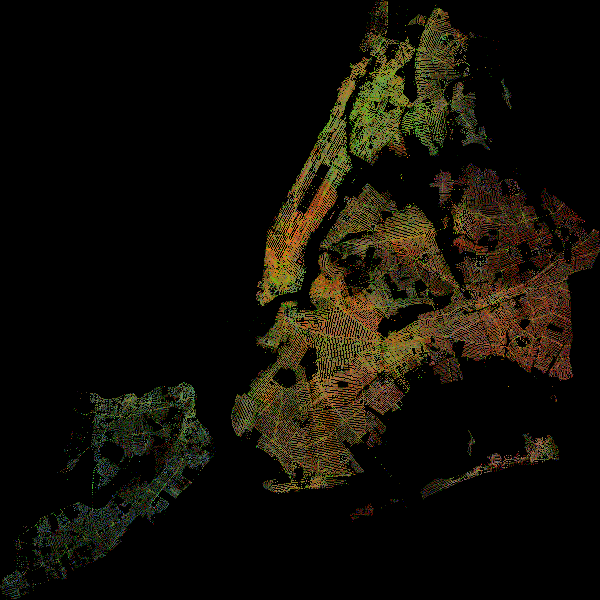

In [7]:
# Export categorical map
export(tf.shade(agg, color_key = color_key, how = 'eq_hist'), 'export')*2

Wow, that was very straight forward. It does not take much code at all to generate a map like this if the data is in the right format. If I'm reading this right, we see a lot of felonies in parts of Manhattan, Brooklyn, and Queens. We primarily see violations on Staten Island (relatively safe area...? I don't know much about Staten Island), and misdemeanors in Manhattan north and the Bronx. That's interesting because, in the last post, the Bronx looked like it was riddled with crime and Queens was lighter. It turns out that the Bronx has a lot of crime but not many felonies, and Queens doesn't have much crime but those that do happen are commonly felonies.

Within Manhattan, there is a pretty clear divide. The lower half of the island experiences more felonies, whereas the upper half of the island experiences more misdemeanors. Zoning in on Manhattan, here is the neighbourhood breakdown:

<img src="https://i.pinimg.com/originals/d9/a1/ea/d9a1eadfcaa495aae3d8f17450468c77.gif" width="400">

Bringing back our total crime density map from the last post, except taking the top 3% of crime density areas:

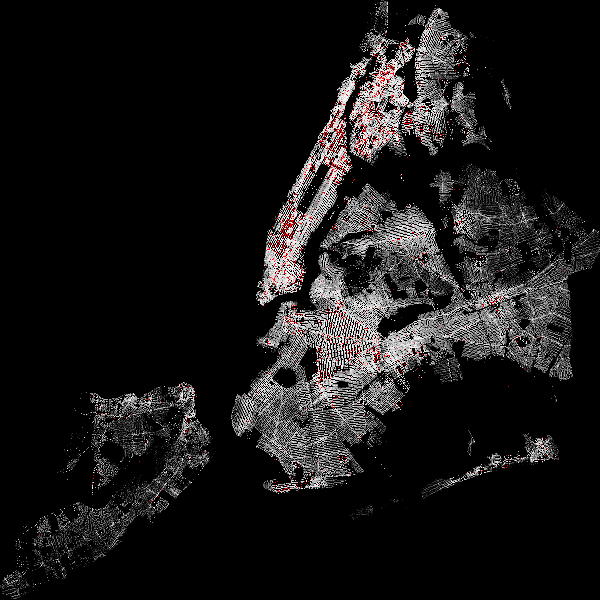

In [11]:
# Show top 3% of crime areas
cvs = ds.Canvas()
agg = cvs.points(df, 'LON', 'LAT')
grays2 = cm([(i,i,i) for i in np.linspace(0,255,97)])
grays2 += ['red', 'red', 'red']
export(tf.shade(agg, cmap = grays2, how = 'eq_hist'), "export")

It looks like the worst neighbourhoods in Manhattan are are midtown and parts of downtown. This is judging by
1. The density of crimes in these areas (both show up in the top 3% of areas with most crime)
2. The seriousness of the crimes (felonies are frequent)

It's interesting because these are the places I've always visited when I went to NYC haha. You look at midtown and you see the likes of Times Square, 30 Rock, MoMA... all your normal tourist attractions! You go downtown a bit and you get to Empire State, lots of cool shops and restaurants, and I'm pretty sure I even saw [Sleep No More](https://mckittrickhotel.com/) around that area a few years ago.

This seems a bit backwards, but I don't live in NYC so I can't pretend to know what the areas are really like... I just wandered around the populated areas for a few days at a time. [This Business Insider article](http://www.businessinsider.com/most-dangerous-neighborhoods-in-new-york-2011-9/#hunts-point-8) actually confirms some of the takeaways from my visualization. It also provides an interesting perspective under the description of the _**second worst neighbourhood in NYC**_, Greenwich Village and Meatpacking District:

> _**Where there are wealthy residents, college students and tourists meandering through busy commerical strips, there is usually thievery. That's why the Village and Meatpacking, despite being one of the most sought after neighborhoods in the city, is second-to-last in property crime, grand larceny, and overall crime.**_

I'd have to pull in some other data sources to actually confirm these, but good to at least find _**some**_ aligning opinions. The article says the following about midtown as well:

> _**Only 74,717 people live in the Midtown, but the sheer number of tourists, office and support workers and general wanderers make the center of Manhattan one of the most trafficked areas in the city.**_

Jumping back to the 10,000 ft view, we're looking at _**all crimes**_ here, but is a Grand Larceny the same as a Dangerous Drugs? Absolutely not. They work in very different ways (not that I've ever committed either!). If I had a hypothesis, I'd assume that Dangerous Drugs crimes are not being committed frequently in these populated areas because they are likely wanting minimize attention drawn to them. Larceny, on the other hand, can _**only**_ happen when people are around, otherwise what are you stealing? Let's break the crimes up further into the offense descrtiptions.

## Mapping By Offense Description

In [4]:
%%time
# Load to pandas dataframe
df = fp_obj.to_pandas(['LAT', 'LON', 'OFFENSE_DESCRIPTION'])

CPU times: user 1.36 s, sys: 48 ms, total: 1.41 s
Wall time: 3.27 s


In [5]:
# Convert OFFENSE_DESCRIPTION to category column type and filter for only Grand Larceny and Dangerous Drugs
df = df[df['OFFENSE_DESCRIPTION'].isin(['GRAND LARCENY', 'DANGEROUS DRUGS'])]
df['OFFENSE_DESCRIPTION'] = df['OFFENSE_DESCRIPTION'].astype('category')

print('df filtered down {} rows'.format(df.shape[0]))
print('Categories in df: {}'.format(df['OFFENSE_DESCRIPTION'].unique()))

df filtered down 816977 rows
Categories in df: [DANGEROUS DRUGS, GRAND LARCENY]
Categories (2, object): [DANGEROUS DRUGS, GRAND LARCENY]


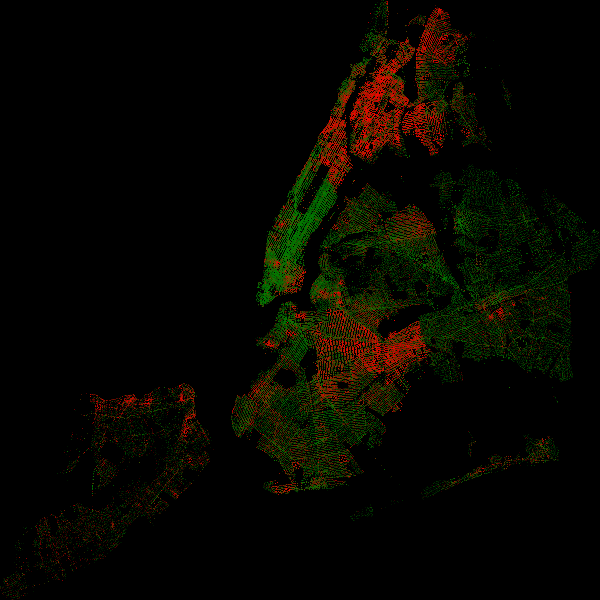

In [6]:
# Create datashader plot
color_key = {'GRAND LARCENY':'green', 'DANGEROUS DRUGS':'red'}
cvs = ds.Canvas()
agg = cvs.points(df, 'LON', 'LAT', ds.count_cat('OFFENSE_DESCRIPTION'))
export(tf.shade(agg, color_key = color_key, how = 'eq_hist'), 'export')

Wow, my hypothesis is bang on! I've never felt smarter in my life. People don't cook up and deal drugs near lots of other people - confirmed.

![](https://media.tenor.com/images/a0e679de4e4c8a92f72662b30738d321/tenor.gif)

You can literally _**see**_ the divide between upper Manhattan and Harlem. This absolutely marks the distinction of tourist areas of NYC I've visited vs areas I've never visited.

Let's throw in Harrassment as well and see what happens

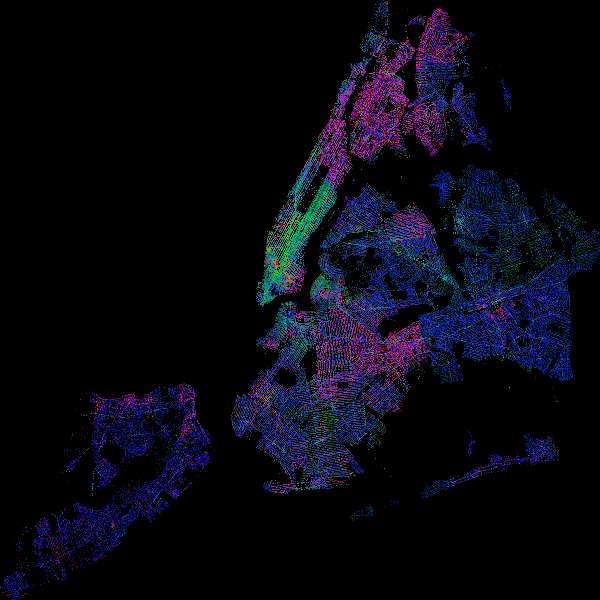

In [8]:
# Load to pandas dataframe
df = fp_obj.to_pandas(['LAT', 'LON', 'OFFENSE_DESCRIPTION'])

# Filter and format
df = df[df['OFFENSE_DESCRIPTION'].isin(['GRAND LARCENY', 'DANGEROUS DRUGS', 'HARRASSMENT 2'])]
df['OFFENSE_DESCRIPTION'] = df['OFFENSE_DESCRIPTION'].astype('category')

# Create datashader plot
color_key = {'HARRASSMENT 2':'blue', 'GRAND LARCENY':'green', 'DANGEROUS DRUGS':'red'}
cvs = ds.Canvas()
agg = cvs.points(df, 'LON', 'LAT', ds.count_cat('OFFENSE_DESCRIPTION'))
export(tf.shade(agg, color_key = color_key, how = 'eq_hist'), 'export')*2

Harrassment is much more common than either of the other 2 offenses, so it seems to take over. Harrassment is also only a violation, so it's a "weaker" crime relatively as well. As a result, areas which show more Grand Larceny or Dangerous Drug crimes are really making a statement. In midtown Manhattan, _**Grand Larceny is often more common than Harrassment**_! That just seems crazy that there are literally more thefts over \$2000 than somebody being followed. Same goes for Dangerous Drugs in the Harlem, Bronx, and Brooklyn areas. The north edge of Staten Island also has quite a bit of drug activity... interesting haha maybe those are industrial areas with abandoned warehouses / docks maybe conducive to cooking drugs? Who knows, I am absolutely making things up at this point.

Using a _**bit**_ of logic and thinking things over, Grand Larceny is actually not too difficult to achieve. Although it is a felony, if you stole someone's MacBook Pro and their wallet, you may be walking away with over \$2000 in value. In an area where there are a ton of students and hipsters, a MacBook Pro may not be too difficult to find! This may speak to the area altogether as well because upper / midtown / lower Manhattan is where many office jobs, nice restaurants, tourist attractions are. If we look at the Upper East Side, a fur coat stolen may be tens of thousands of dollars, let alone \$2000. Maybe this has a commentary on the standard of living / demographics / occupations of these areas of NYC. I don't know though, I only know what I learned from Gossip Girl.

<img src="https://m.popkey.co/50b25a/Y96vg.gif" width="400">

That's right. I'm man enough to say it. No shame.

## Mapping By Premise Description
Okay, let's slice and dice this map one more way.

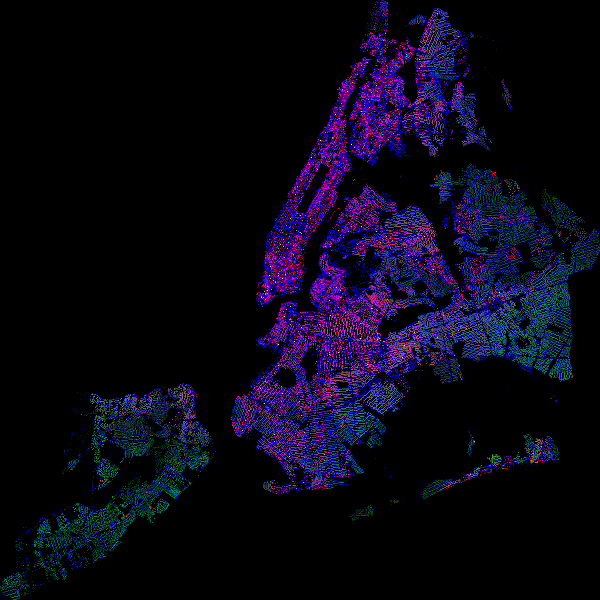

In [3]:
# Load to pandas dataframe
df = fp_obj.to_pandas(['LAT', 'LON', 'PREMISE_DESCRIPTION'])

# Filter and format
df = df[df['PREMISE_DESCRIPTION'].isin(['STREET', 'RESIDENCE - APT. HOUSE', 'RESIDENCE-HOUSE', 'TRANSIT - NYC SUBWAY'])]
df['PREMISE_DESCRIPTION'] = df['PREMISE_DESCRIPTION'].astype('category')


# Create datashader plot
color_key = {'STREET':'blue', 'RESIDENCE - APT. HOUSE':'red', 'RESIDENCE-HOUSE':'green', 'TRANSIT - NYC SUBWAY':'yellow'}
cvs = ds.Canvas()
agg = cvs.points(df, 'LON', 'LAT', ds.count_cat('PREMISE_DESCRIPTION'))
export(tf.shade(agg, color_key = color_key, how = 'eq_hist'), 'export')*2

I don't think this tell me too much about crime in general, but it sure helps me paint a picture of the urban planning of NYC. We see exactly where the boundaries of NYC are defined by the streets, where there exists more apartments or houses (or, at least where there is more crime being committed in either type of dwelling, which I will make the loose assumption of it being directly correlated to the types of dwelling available), and where the subway stations are.

I've never been to the parts of NYC where there are lots of houses. I've visited throughout Manhattan and Brooklyn, so my memory can loosely confirm that I really only did see smaller apartment style dwellings. Like I mentioned in the last paragraph, I want to make the distinction between this map actually telling me what types of dwellings exist where, and the types of dwellings in which _**crimes happen in**_. For example, in Manhattan, is the map telling us that there only _**exists**_ apartments, or that there exists an abundant amount of both apartments and houses but crimes _**only happen**_ in apartments? Having been to NYC, I can confirm that there are barely any houses in Manhattan, but I can't make the same assumptions for the east boundary of Queens or Staten Island where more crimes happen in houses. Some logic does tell me that areas like Staten Island and Queens are a bit more domesticated, but I just can't say that for sure because I've never been there, and the map does not answer that specific question for me.

Let's quickly try 3 more categories within PREMISE\_DESCRIPTION. I almost just want to get more insights into the urban planning of NYC at this point haha.

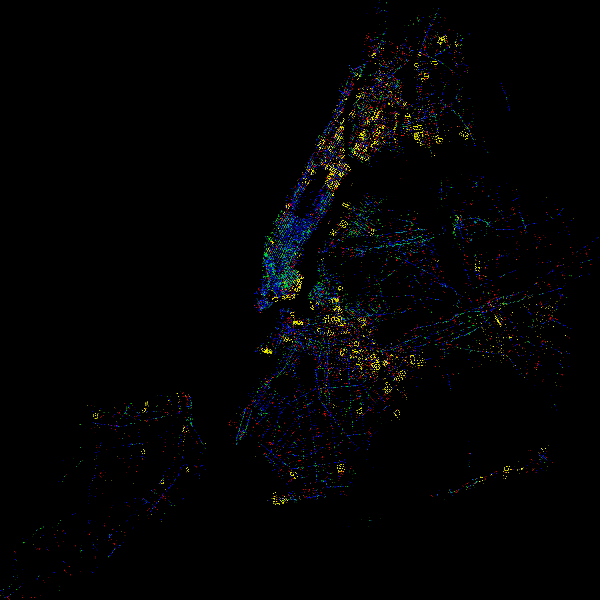

In [9]:
# Load to pandas dataframe
df = fp_obj.to_pandas(['LAT', 'LON', 'PREMISE_DESCRIPTION'])

# Filter and format
df = df[df['PREMISE_DESCRIPTION'].isin(['RESTAURANT/DINER', 'RESIDENCE - PUBLIC HOUSING', 'PUBLIC SCHOOL', 'BAR/NIGHT CLUB'])]
df['PREMISE_DESCRIPTION'] = df['PREMISE_DESCRIPTION'].astype('category')


# Create datashader plot
color_key = {'RESTAURANT/DINER':'blue', 'PUBLIC SCHOOL':'red', 'BAR/NIGHT CLUB':'green', 'RESIDENCE - PUBLIC HOUSING':'yellow'}
cvs = ds.Canvas()
agg = cvs.points(df, 'LON', 'LAT', ds.count_cat('PREMISE_DESCRIPTION'))
export(tf.shade(agg, color_key = color_key, how = 'eq_hist'), 'export')*2

A lot of these maps are telling very similar stores to one another.